How does the velocity compare for observations made on opposite sides of the galaxy?

In [59]:
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value

# Data

## Iron

In [3]:
# tiron_all = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_iron_healpix.fits')
tiron_all = Table.read('/Users/kdouglass/Documents/Research/data/DESI/Y1/desi_pv_tf_iron_healpix.fits')
tiron = unique(tiron_all)
tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
-411444222,156.21815002209,7.15848284808457,27449,main,0.102481637685212,9.09103522467823e-05,2053,0.0467898591887206,iron/healpix/main/backup/274/27449/redrock-main-backup-27449.fits,TFT,4614,156.21810707253144,7.1582430702316175
-256075243,267.712765090224,29.4851124724098,32659,main,0.0249376137955555,2.44308294845057e-05,2560,1544.51990368162,iron/healpix/main/bright/326/32659/redrock-main-bright-32659.fits,SGA,447725,267.7127798938763,29.484990855307803
-255474428,318.116492659747,-5.28401899381209,49107,main,0.0489536329997778,7.85721765764138e-05,512,67.7162851418252,iron/healpix/main/bright/491/49107/redrock-main-bright-49107.fits,TFT,342501,318.1167585749797,-5.283990383719008
-239472210,323.502907257596,2.59623615801086,19168,main,0.0570545794337428,2.47376442711859e-05,2560,36.3351525710896,iron/healpix/main/bright/191/19168/redrock-main-bright-19168.fits,TFT,1245160,323.5028651783498,2.5963714595607508
-236269010,159.441551301486,11.8164401561333,27589,main,0.0536937948152313,2.00541500335771e-06,2560,17253.9541264772,iron/healpix/main/bright/275/27589/redrock-main-bright-27589.fits,SGA,112426,159.44167440686755,11.816368587372878


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [4]:
tiron['ZERR_MOD'] = np.sqrt(tiron['ZERR']**2 + dz_sys**2)

## SGA

In [5]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the Iron data into center and off-center observations

In [7]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|███████████████████████████████████| 75152/75152 [00:35<00:00, 2135.11it/s]


In [8]:
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

## Clean the Iron center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [9]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [10]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers['ZERR']**2)
weights = 1./(good_centers['ZERR_MOD']**2)

n = 0

delta_z = np.array([])

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    n_obs = np.sum(obs_idx)
    
    # Find the row in the SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Compute the uncertainty in the center redshift
    if n_obs == 1 or np.all(np.abs(good_centers['ZERR_MOD'][obs_idx]/good_centers['Z'][obs_idx]) < 0.05):
        SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(n_obs*np.sum(weights[obs_idx])))
    else:
        z_random = np.zeros((n_obs, N_samples))

        for i in range(n_obs):
            z_random[i] = rng.normal(loc=good_centers['Z'][obs_idx][i], 
                                     scale=good_centers['ZERR_MOD'][obs_idx][i], 
                                     size=N_samples)

        avg_z_random = np.average(z_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)

        SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)
    
    # If there is more than one center observation
    if n_obs > 1:
        
        diff_matrix = good_centers['Z'][obs_idx].reshape(n_obs,1) - good_centers['Z'][obs_idx].reshape(1,n_obs)
            
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
            
        delta_z = np.append(delta_z, diffs)
        '''
        if np.any(np.abs(diffs*c).value > 50.):

            print(sga_id)
            print(c*diffs)
            print(good_centers[['TARGETID', 'Z', 'PVTYPE', 'FILENAME', 'SKY_FIBER_DIST_R26', 'RA', 'DEC']][good_centers['SGA_ID'] == sga_id].pprint(max_width=-1))
        '''
        n += 1
        
print(n)

100%|███████████████████████████████████| 70100/70100 [00:09<00:00, 7708.10it/s]

4549


### Plot a histogram of the difference in velocities for the good centers

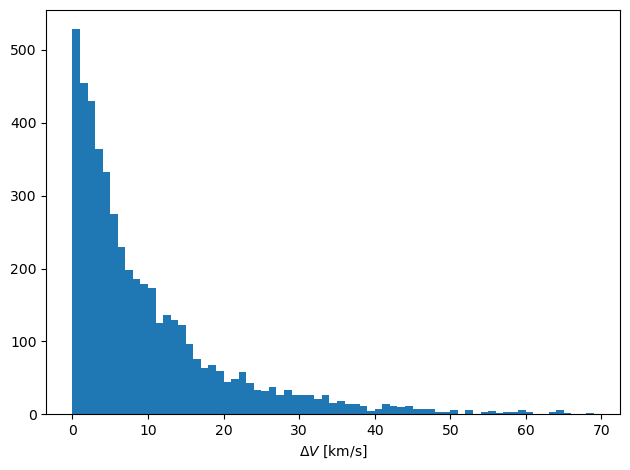

In [12]:
plt.figure(tight_layout=True)

plt.hist(np.abs(delta_z*c).value, bins=np.arange(0,70,1))

plt.xlabel('$\Delta V$ [km/s]');

# Calculate the rotational velocities

In [13]:
iron_axis['V_ROT'] = np.nan
iron_axis['V_ROT_ERR'] = np.nan
iron_axis['CENTER_TARGETID'] = 0
iron_axis['CENTER_TARGETID'].dtype = np.int64

# For each SGA galaxy that has at least one good center observation, calculate 
# the rotational velocity for all of that galaxy's targets
for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = iron_axis['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all of the center observations for the 
    # systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]
    
    # Calculate the rotational velocity for all observations of the galaxy
    z_rot = (1 + iron_axis['Z'][obs_idx])/(1 + z_center) - 1
    iron_axis['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(iron_axis['ZERR_MOD'][obs_idx]/iron_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
        iron_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((iron_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + iron_axis['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(loc=z_center, 
                                     scale=z_err_center, 
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(loc=iron_axis['Z'][obs_idx][i], 
                                          scale=iron_axis['ZERR_MOD'][obs_idx][i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        iron_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0.
        
    iron_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Set center TARGETID in table
    #---------------------------------------------------------------------------
    centers_idx = good_centers['SGA_ID'] == sga_id
    
    if sum(centers_idx) > 1:
        # Take the smaller TARGETID - more likely to be main survey and not backup
        iron_axis['CENTER_TARGETID'][obs_idx] = np.min(good_centers['TARGETID'][centers_idx])
    else:
        iron_axis['CENTER_TARGETID'][obs_idx] = good_centers['TARGETID'][centers_idx]
    #---------------------------------------------------------------------------

100%|████████████████████████████████████| 70100/70100 [03:40<00:00, 317.92it/s]


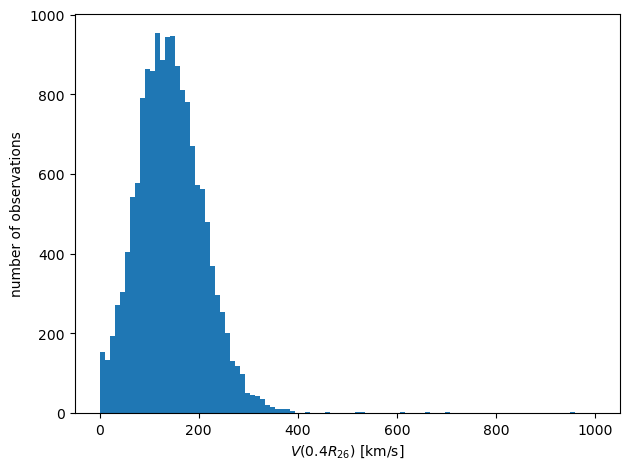

In [14]:
plt.figure(tight_layout=True)

plt.hist(np.abs(iron_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for the TFR

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.4R_{26}$
* `ZWARN` != [SKY, UNPLUGGED, BAD_TARGET, NODATA]

## Velocity cut

In [15]:
r0p4 = (iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)

Vgood = (np.abs(iron_axis['V_ROT']) < 1000) & (np.abs(iron_axis['V_ROT']) >= 10)

good_axis = iron_axis[r0p4 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

15082 10502


## `ZWARN` cut

In [16]:
ZWARNBITS = dict(
    SKY               = 2**0,  #- sky fiber
    LITTLE_COVERAGE   = 2**1,  #- too little wavelength coverage
    SMALL_DELTA_CHI2  = 2**2,  #- chi-squared of best fit is too close to that of second best
    NEGATIVE_MODEL    = 2**3,  #- synthetic spectrum is negative
    MANY_OUTLIERS     = 2**4,  #- fraction of points more than 5 sigma away from best model is too large (>0.05)
    Z_FITLIMIT        = 2**5,  #- chi-squared minimum at edge of the redshift fitting range
    NEGATIVE_EMISSION = 2**6,  #- a QSO line exhibits negative emission, triggered only in QSO spectra, if  C_IV, C_III, Mg_II, H_beta, or H_alpha has LINEAREA + 3 * LINEAREA_ERR < 0
    UNPLUGGED         = 2**7,  #- the fiber was unplugged/broken, so no spectrum obtained
    BAD_TARGET        = 2**8,  #- catastrophically bad targeting data
    NODATA            = 2**9,  #- No data for this fiber, e.g. because spectrograph was broken during this exposure (ivar=0 for all pixels)
    BAD_MINFIT        = 2**10, #- Bad parabola fit to the chi2 minimum
    POORDATA          = 2**11, #- Poor input data quality but try fitting anyway
    #- The following bits are reserved for experiment-specific post-redrock
    #- afterburner updates to ZWARN; redrock commits to *not* setting these bits
    RESERVED16        = 2**16,
    RESERVED17        = 2**17,
    RESERVED18        = 2**18,
    RESERVED19        = 2**19,
    RESERVED20        = 2**20,
    RESERVED21        = 2**21,
    RESERVED22        = 2**22,
    RESERVED23        = 2**23
)

In [17]:
zwarn_reject = good_axis['ZWARN'] & (ZWARNBITS['SKY'] | ZWARNBITS['UNPLUGGED'] | ZWARNBITS['BAD_TARGET'] | ZWARNBITS['NODATA']) != 0

good_axis_zwarn = good_axis[~zwarn_reject]

print(len(good_axis_zwarn), len(np.unique(good_axis_zwarn['SGA_ID'])))

15076 10498


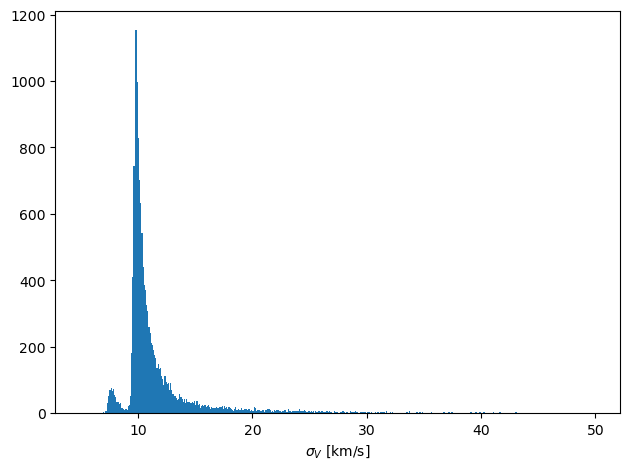

In [21]:
plt.figure(tight_layout=True)

plt.hist(good_axis['V_ROT_ERR'], bins=np.arange(5,50,0.1))

plt.xlabel('$\sigma_V$ [km/s]');

In [24]:
# good_axis[['ZWARN', 'DELTACHI2', 'ZERR', 'V_ROT_ERR']][good_axis['ZERR'] < 1e-10].show_in_notebook()
np.unique(good_axis['ZWARN'])

0
2
4
6
512
2048
2560


In [25]:
good_axis.sort('SGA_ID')
good_axis[:10]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,ZERR_MOD,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,V_ROT,V_ROT_ERR,CENTER_TARGETID
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,int64
2390410135601155,211.663819619684,39.5274289579135,10641,main,0.0805801767009853,8.1517906871694e-06,0,355.434564262629,iron/healpix/main/bright/106/10641/redrock-main-bright-10641.fits,TFT,38,211.66381961968403,39.527428957913536,2.4731563211283164e-05,0.0013919312850436262,0.40000000273488895,-122.3223893029039,9.671537005812278,39633067991634288
2389570544992261,199.730072385194,1.72783181582658,26207,main,0.043724082715951,2.00020412004933e-05,0,87.385311095044,iron/healpix/main/bright/262/26207/redrock-main-bright-26207.fits,TFT,55,199.73007238519418,1.7278318158265755,3.074540908253628e-05,0.0016522717242376344,0.40000001839639326,-90.86051978111053,11.635028986228761,39627830354515481
2389570544992262,199.731168566683,1.72471420712763,26207,main,0.0442278866180755,4.93823865132347e-06,0,987.540528729558,iron/healpix/main/bright/262/26207/redrock-main-bright-26207.fits,TFT,55,199.7311685666833,1.7247142071276316,2.3865974282306138e-05,0.001652271724239446,0.40000001839683186,74.06517617086439,10.218712152721638,39627830354515481
2389593684967425,138.936887947814,2.69359099571864,27323,main,0.0894207867179649,1.02737993538727e-05,0,294.705438926816,iron/healpix/main/bright/273/27323/redrock-main-bright-27323.fits,TFT,117,138.9368879478137,2.6935909957186372,2.5509791857831926e-05,0.001890833820141368,0.40000000950669173,-180.6557315191658,12.555107762887319,39627853494489271
2390308285317127,197.788671878468,34.1699112536563,10429,main,0.0342435658110361,1.23599866389013e-05,0,106.363333164714,iron/healpix/main/bright/104/10429/redrock-main-bright-10429.fits,TFT,223,197.78867187846762,34.16991125365625,2.641908017286165e-05,0.0019192371848402656,0.4000000017221458,70.1020042633194,10.55954809258847,39632966141349468
2403172219879426,118.8630645994,18.9749210198928,4762,main,0.0437819837652661,8.86355382993115e-06,0,489.882415242493,iron/healpix/main/dark/47/4762/redrock-main-dark-4762.fits,TFT,581,118.86306459939964,18.974921019892815,2.4975209988353654e-05,0.003176771565326198,0.40000002051985095,133.77852107143553,10.574319515162813,39628237889865781
2389606767001601,198.785256377878,3.22061731840355,26402,main,0.0843166188262386,9.91075170383271e-06,0,262.282029911876,iron/healpix/main/bright/264/26402/redrock-main-bright-26402.fits,TFT,669,198.7852563778781,3.2206173184035523,2.536575500160198e-05,0.0020625492796529604,0.40000001666923746,292.50047126155704,10.925611527814912,39627866576519353
2402724666671104,334.313871911252,-0.0668403756826733,19033,main,0.0774092475088331,9.99594298169776e-06,0,293.786512881517,iron/healpix/main/dark/190/19033/redrock-main-dark-19033.fits,TFT,731,334.3138719112516,-0.06684037568267326,2.539916147355313e-05,0.0018798820852912674,0.4000000143668302,81.61279266055006,10.202851574557778,39627790336657394
2389695837241346,125.599288657637,7.03635244797881,22005,main,0.0783386390572901,4.26610581494304e-06,0,1534.63903617859,iron/healpix/main/bright/220/22005/redrock-main-bright-22005.fits,TFT,1135,125.59928865763668,7.036352447978806,2.373601032799244e-05,0.0016725973904302685,0.4000000147336001,-175.3545627727083,9.797048228263035,39627955646764051


In [20]:
# good_axis.write('/global/cfs/projectdirs/desi/science/td/pv/Y1/desi_pv_tf_iron_good-axis.fits', overwrite=True)

### How do the velocities compare for objects that have multiple observations?

Also, keep track of those which would get cut by our $\Delta V / V_\text{min} < 5$ requirement. 

In [26]:
n = 0

delta_v = np.array([])
delta_v_norm_min = np.array([])
delta_v_norm_sigma = np.array([])
deltachi2 = np.array([])
sigma_v = np.array([])
v_norm_min = np.array([])
v_norm_max = np.array([])

good_deltaVs = np.array([])
good_deltaV_norm_sigma = np.array([])

# For observations made on the same side of the galaxy
same_delta_v = np.array([])
same_delta_v_norm_min = np.array([])
same_delta_v_norm_sigma = np.array([])
# same_deltachi2 = np.array([])
# same_v_norm_min = np.array([])
# same_v_norm_max = np.array([])

# same_good_deltaVs = np.array([])
# same_good_deltaV_norm_sigma = np.array([])

# For observations made on opposite sides of the galaxy
opposite_delta_v = np.array([])
opposite_delta_v_norm_min = np.array([])
opposite_delta_v_norm_sigma = np.array([])
# opposite_deltachi2 = np.array([])
# opposite_v_norm_min = np.array([])
# opposite_v_norm_max = np.array([])

# opposite_good_deltaVs = np.array([])
# opposite_good_deltaV_norm_sigma = np.array([])

deltachi2_idx = good_axis['DELTACHI2'] >= 25

for sga_id in tqdm(np.unique(good_axis['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:

        # Make a copy of table with just this galaxy's observations
        this_gal = good_axis[obs_idx]
        
        v_min = np.min(np.abs(this_gal['V_ROT']))
        v_max = np.max(np.abs(this_gal['V_ROT']))
        
        v_norm_min = np.append(v_norm_min, np.abs(this_gal['V_ROT'])/v_min)
        v_norm_max = np.append(v_norm_max, np.abs(this_gal['V_ROT'])/v_max)
        
        deltachi2 = np.append(deltachi2, this_gal['DELTACHI2'])
        sigma_v = np.append(sigma_v, this_gal['V_ROT_ERR'])
        
        diff_matrix = np.abs(this_gal['V_ROT']).reshape(n_obs,1) - np.abs(this_gal['V_ROT']).reshape(1,n_obs)
        
        diff_matrix_norm = diff_matrix/v_min
        
        sigma_matrix = np.sqrt(this_gal['V_ROT_ERR'].reshape(n_obs,1)**2 + this_gal['V_ROT_ERR'].reshape(1,n_obs)**2)
        
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
        
        sigmas = sigma_matrix[np.triu_indices(n_obs, k=1)]
        
        diffs_norm = diffs/v_min
        
        diffs_norm_sigma = diffs/sigmas
        
        delta_v = np.append(delta_v, diffs)
        
        delta_v_norm_min = np.append(delta_v_norm_min, diffs_norm)
        
        delta_v_norm_sigma = np.append(delta_v_norm_sigma, diffs_norm_sigma)
        
        # Compare observations made on same or opposite side of galaxy
        for i in range(n_obs):
            for j in range(i+1, n_obs):
                
                diff = np.abs(this_gal['V_ROT'][i]) - np.abs(this_gal['V_ROT'][j])
                sigma = np.sqrt(this_gal['V_ROT_ERR'][i]**2 + this_gal['V_ROT_ERR'][j]**2)
                
                # Same side of galaxy
                if (this_gal['TARGET_RA'][i] == this_gal['TARGET_RA'][j]) & (this_gal['TARGET_DEC'][i] == this_gal['TARGET_DEC'][j]):
                    same_delta_v = np.append(same_delta_v, diff)
                    same_delta_v_norm_min = np.append(same_delta_v_norm_min, diff/v_min)
                    same_delta_v_norm_sigma = np.append(same_delta_v_norm_sigma, diff/sigma)
                
                # Opposite side of galaxy
                else:
                    opposite_delta_v = np.append(opposite_delta_v, diff)
                    opposite_delta_v_norm_min = np.append(opposite_delta_v_norm_min, diff/v_min)
                    opposite_delta_v_norm_sigma = np.append(opposite_delta_v_norm_sigma, diff/sigma)
        
        ########################################################################
        # For Delta V / Vmin cut
        #-----------------------------------------------------------------------
        if np.any(np.abs(diff_matrix_norm) > 5):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, 
            # they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.all(np.abs(diff_matrix_norm) <= 5):
                    
                    sigma_matrix = np.sqrt(good_axis['V_ROT_ERR'][good_obs_idx].reshape(n_obs_good,1)**2 + good_axis['V_ROT_ERR'][good_obs_idx].reshape(1,n_obs_good)**2)
                    
                    good_deltaVs = np.append(good_deltaVs, diff_matrix[np.triu_indices(n_obs_good, k=1)])
                    good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, 
                                                       diff_matrix[np.triu_indices(n_obs_good, k=1)]/sigma_matrix[np.triu_indices(n_obs_good, k=1)])
        else:
            good_deltaVs = np.append(good_deltaVs, diffs)
            good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, diffs_norm_sigma)
        ########################################################################
        
        n += 1
        
print(n)

100%|███████████████████████████████████| 10502/10502 [00:01<00:00, 7600.78it/s]

3253


In [27]:
print(len(same_delta_v), len(opposite_delta_v))
print(len(delta_v))

2115 4266
6381


#### Plot a histogram of the difference in rotational velocities

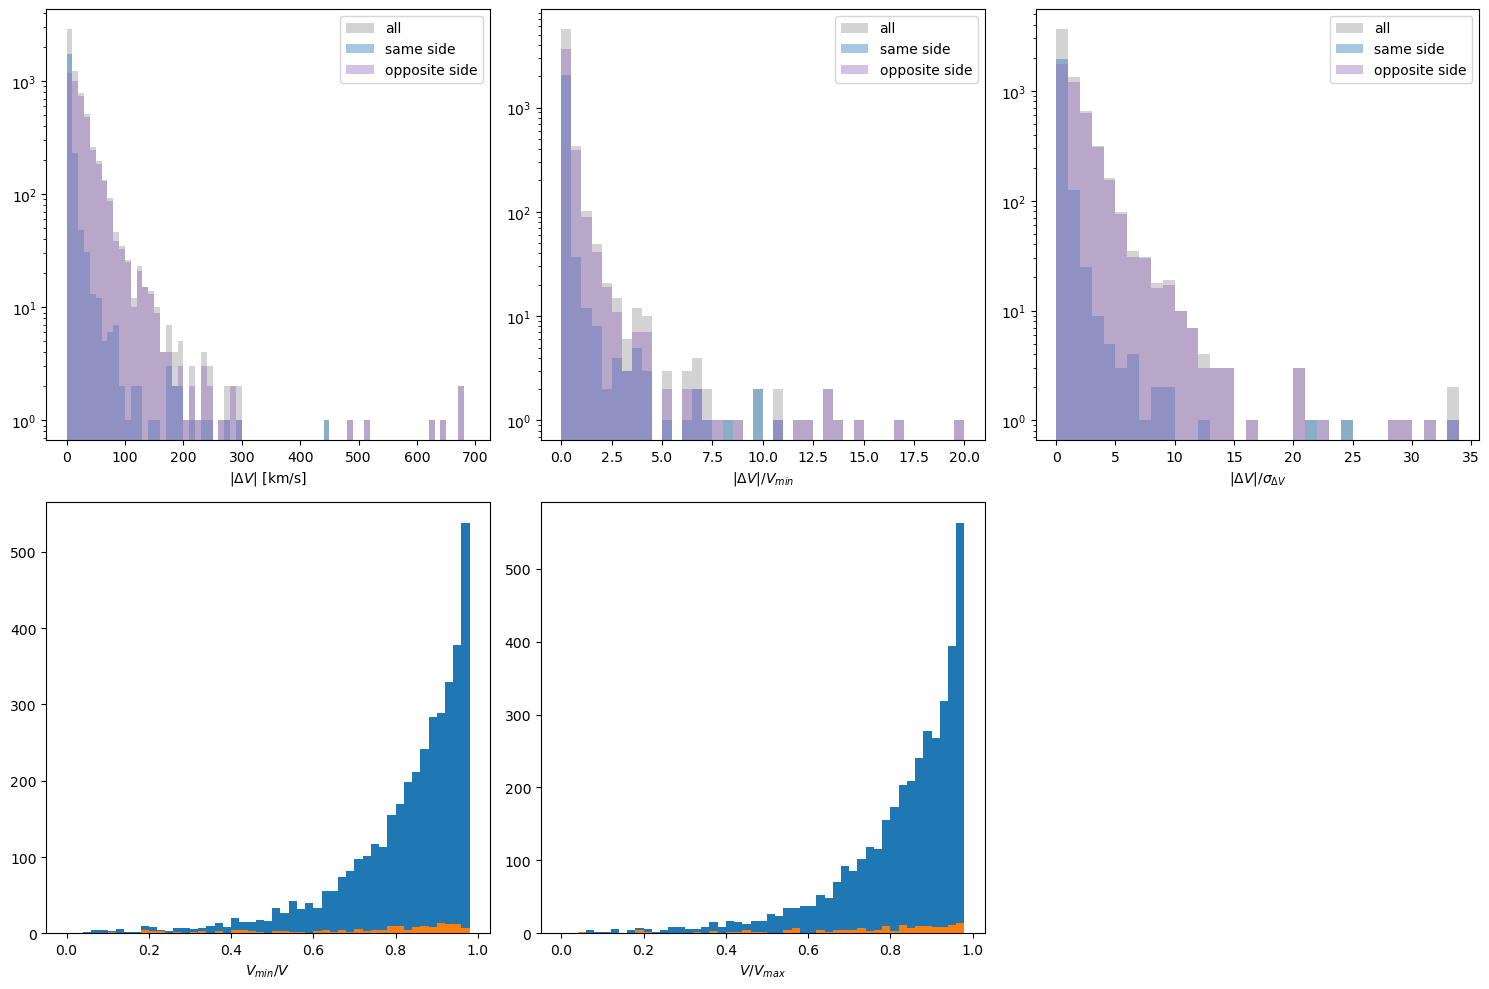

In [35]:
plt.figure(tight_layout=True, figsize=(15,10))


#-------------------------------------------------------------------------------
plt.subplot(231)

bins = np.arange(0,700,10)
plt.hist(np.abs(delta_v), color='lightgray', bins=bins, label='all')
plt.hist(np.abs(same_delta_v), color='tab:blue', alpha=0.4, bins=bins, label='same side')
plt.hist(np.abs(opposite_delta_v), color='tab:purple', alpha=0.4, bins=bins, label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('|$\Delta V$| [km/s]')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(232)

bins = np.arange(0,20.5,0.5)
plt.hist(np.abs(delta_v_norm_min), color='lightgray', bins=bins, label='all')
plt.hist(np.abs(same_delta_v_norm_min), color='tab:blue', alpha=0.4, bins=bins, label='same side')
plt.hist(np.abs(opposite_delta_v_norm_min), color='tab:purple', alpha=0.4, bins=bins, label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('$|\Delta V| / V_{min}$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(233)

bins = np.arange(0,35,1)
plt.hist(np.abs(delta_v_norm_sigma), color='lightgray', bins=bins, label='all')
plt.hist(np.abs(same_delta_v_norm_sigma), color='tab:blue', alpha=0.4, bins=bins, label='same side')
plt.hist(np.abs(opposite_delta_v_norm_sigma), color='tab:purple', alpha=0.4, bins=bins, label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(234)

bins = np.arange(0,1,0.02)
plt.hist(1/v_norm_min, bins=bins)
plt.hist(1/v_norm_min[deltachi2 < 25], bins=bins)

#plt.yscale('log')

plt.xlabel('$V_{min} / V$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(235)

bins = np.arange(0,1,0.02)
plt.hist(v_norm_max, bins=bins)
plt.hist(v_norm_max[deltachi2 < 25], bins=bins)

#plt.yscale('log')

plt.xlabel('$V / V_{max}$');
#-------------------------------------------------------------------------------

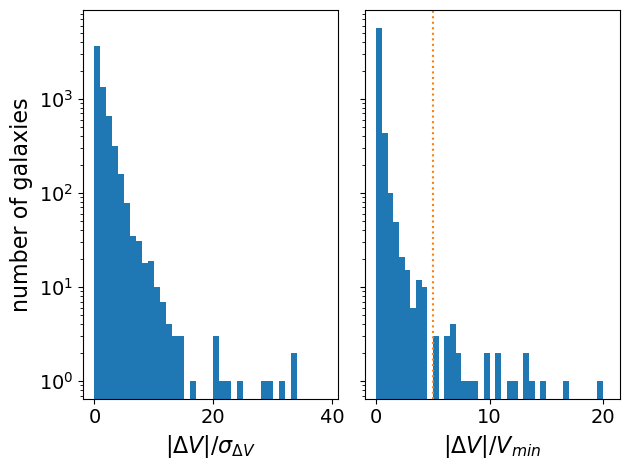

In [38]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 40, 1))
# plt.hist(np.abs(good_deltaV_norm_sigma), fill=False, hatch='x', bins=np.arange(0, 125, 5))
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist(np.abs(delta_v_norm_min), bins=np.arange(0,21,0.5))
plt.vlines(5, 0, 10000, colors='tab:orange', linestyles='dotted')
plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$|\Delta V| / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_deltaVlog_20240619.png', dpi=150);

/var/folders/mg/fxh1s24d0n3_r0c39d3gs0g00000gq/T/ipykernel_43477/3576450384.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('../../../figures/Y1_papers/iron_deltaVlog_sameVopposite_20250724.png',


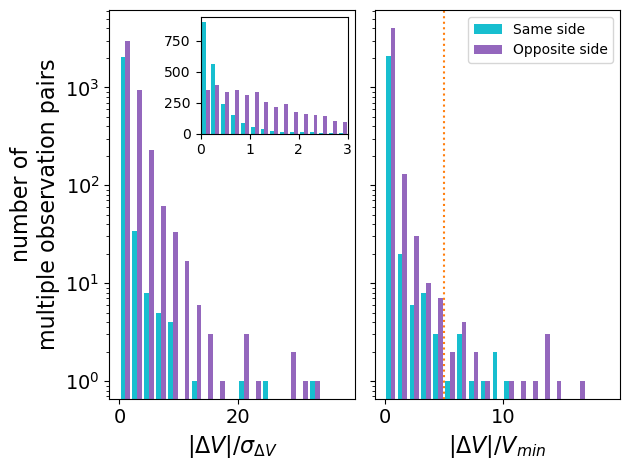

In [63]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
plt.hist([np.abs(same_delta_v_norm_sigma), np.abs(opposite_delta_v_norm_sigma)], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(0,40,2))

plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)
plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of\nmultiple observation pairs', fontsize=16)

axins = inset_axes(ax1, width='60%', height='30%', loc='upper right')
plt.hist([np.abs(same_delta_v_norm_sigma), np.abs(opposite_delta_v_norm_sigma)], 
         bins=np.arange(0, 40, 0.2), 
         color=['tab:cyan', 'tab:purple'])
plt.xlim([0, 3])


ax2 = plt.subplot(122, sharey=ax1)
plt.hist([np.abs(same_delta_v_norm_min), np.abs(opposite_delta_v_norm_min)], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(0,20,1), 
         # stacked=True, 
         label=['Same side', 'Opposite side']
        )

plt.legend()

plt.vlines(5, 0, 10000, colors='tab:orange', linestyles='dotted')
plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$|\Delta V| / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/Y1/iron_deltaVlog_sameVopposite_20250404.png', 
plt.savefig('../../../figures/Y1_papers/iron_deltaVlog_sameVopposite_20250724.png', 
            dpi=150, 
            facecolor='None')

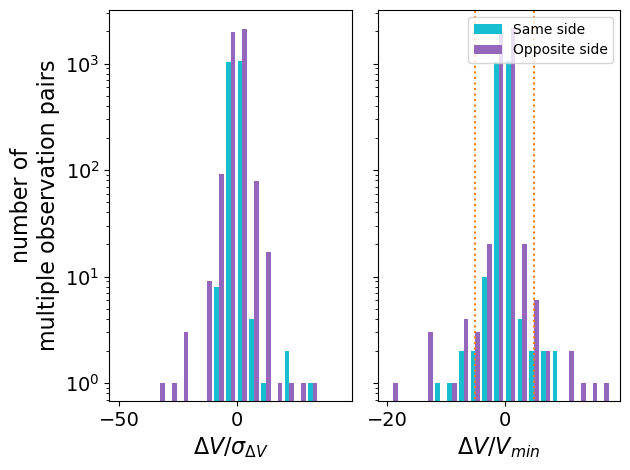

In [55]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
plt.hist([same_delta_v_norm_sigma, opposite_delta_v_norm_sigma], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(-50,50,5), 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$\Delta V / \sigma_{\Delta V}$', fontsize=16)

# plt.legend()

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of\nmultiple observation pairs', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist([same_delta_v_norm_min, opposite_delta_v_norm_min], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(-20,20,2), 
         # stacked=True
         label=['Same side', 'Opposite side']
        )
plt.vlines([-5, 5], 0, 10000, colors='tab:orange', linestyles='dotted')

plt.legend()

plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$\Delta V / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_deltaVlog_20240619.png', dpi=150);

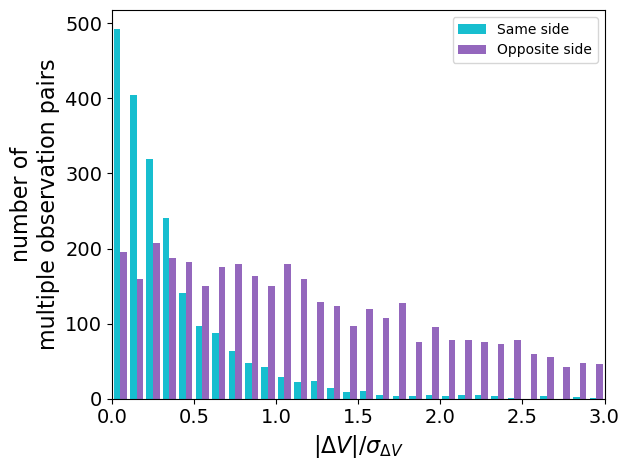

In [53]:
plt.figure(tight_layout=True)

# plt.grid()

# plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 0.1))
plt.hist([np.abs(same_delta_v_norm_sigma), np.abs(opposite_delta_v_norm_sigma)], 
         bins=np.arange(0, 50, 0.1), 
         color=['tab:cyan', 'tab:purple'], 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.legend()

plt.xlim([0, 3])

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of\nmultiple observation pairs', fontsize=16);

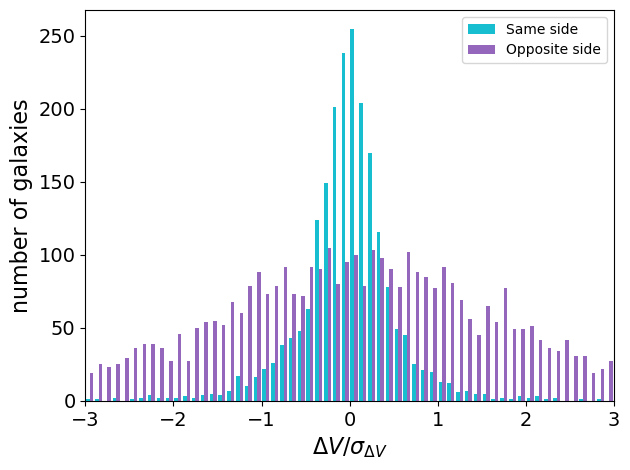

In [47]:
plt.figure(tight_layout=True)

# plt.grid()

# plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 0.1))
plt.hist([same_delta_v_norm_sigma, opposite_delta_v_norm_sigma], 
         bins=np.arange(-50, 50, 0.1), 
         color=['tab:cyan', 'tab:purple'], 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$\Delta V / \sigma_{\Delta V}$', fontsize=16)

plt.legend()

plt.xlim([-3, 3])

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16);

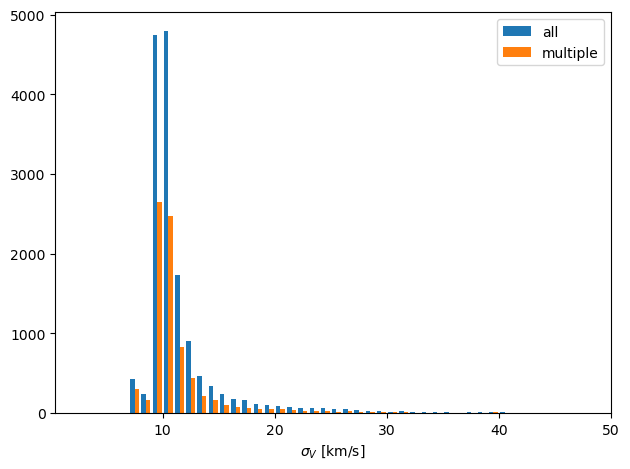

In [49]:
plt.figure(tight_layout=True)

plt.hist([good_axis['V_ROT_ERR'], sigma_v], 
         bins=np.arange(5,100,1), 
         label=['all', 'multiple'])

plt.xlim(xmax=50)

plt.legend()

plt.xlabel('$\sigma_V$ [km/s]');

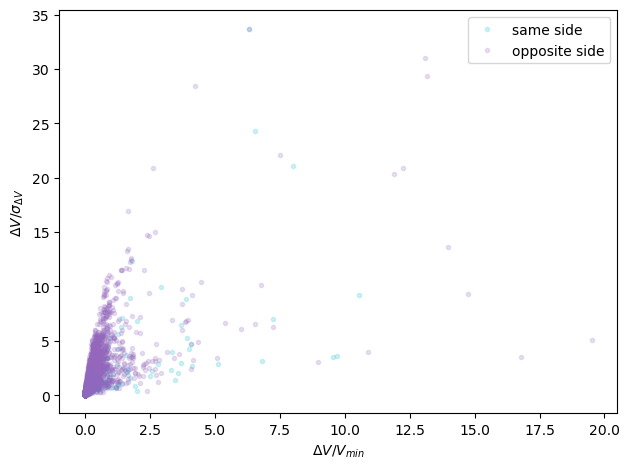

In [50]:
plt.figure(tight_layout=True)

# plt.plot(np.abs(delta_v_norm_min), np.abs(delta_v_norm_sigma), '.', alpha=0.2)
plt.plot(np.abs(same_delta_v_norm_min), np.abs(same_delta_v_norm_sigma), '.', c='tab:cyan', alpha=0.2, label='same side')
plt.plot(np.abs(opposite_delta_v_norm_min), np.abs(opposite_delta_v_norm_sigma), '.', c='tab:purple', alpha=0.2, label='opposite side')

plt.legend()

plt.xlabel('$\Delta V / V_{min}$')
plt.ylabel('$\Delta V / \sigma_{\Delta V}$');

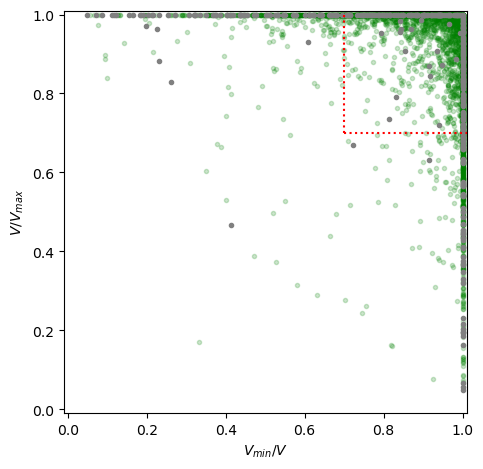

In [51]:
plt.figure(tight_layout=True)

plt.plot(1/v_norm_min[deltachi2 >= 25], v_norm_max[deltachi2 >= 25], 'g.', alpha=0.2)
plt.plot(1/v_norm_min[deltachi2 < 25], v_norm_max[deltachi2 < 25], '.', c='gray')

plt.hlines(0.7, 0.7, 1.1, colors='r', linestyles=':')
plt.vlines(0.7, 0.7, 1.1, colors='r', linestyles=':')

plt.gca().set_aspect('equal', 'box')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.xlabel('$V_{min} / V$')
plt.ylabel('$V / V_{max}$');